In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import random
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from dynamics import *
from plotting import *
from computation import *
from networkParameters import *
import matplotlib.pyplot as plt
import random


[[50  3]]
[[50  3]]


In [2]:
def init_sparse_matrix(sparsity):
    internal_weights = np.random.standard_normal(size=(N, N))
    amount = int((1-sparsity)*N)
    zero_index = []
    for i in range(amount):
        index_1 = random.randint(0, N-1)
        index_2 = random.randint(0, N-1)

        while((index_1, index_2)  in zero_index):
            index_1 = random.randint(0, N-1)
            index_2 = random.randint(0, N-1)
        zero_index.append((index_1, index_2))    
        internal_weights[index_1][index_2] = 0
    return internal_weights

In [3]:
# Initialise network
internal_weights = init_sparse_matrix(0.2)
input_weights = np.random.normal(0, 1, size=(N,2))*0.5
output_weights = np.random.normal(0, 1, size=(N, 2)).transpose()
leaking_matrix = np.identity(N)*a_internal

# scale internal weights
eigenvalues = eigvals(internal_weights)
scaling_factor = max(abs(eigenvalues))
print(scaling_factor)
internal_weights *= desired_spectral_radius/scaling_factor

R = np.eye(N)-leaking_matrix

esp_weights = (np.eye(N)-R)*internal_weights + R
print(max(abs(eigvals(esp_weights)))) 

22.88992118777358
0.4352043099524663


[[50  3]]
[[50  3]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


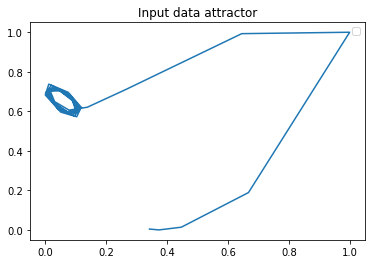

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


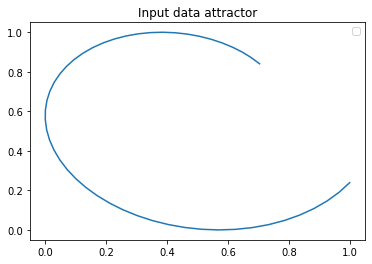

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


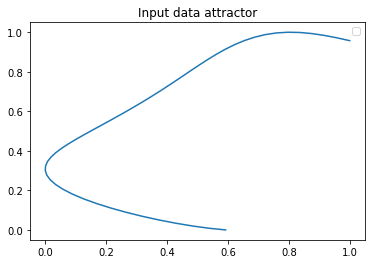

In [4]:
# collect training data for three different "strange" attractors
lorenz_input = generate_attractor_data()
rossler_input = generate_attractor_data([1, 1, 0], rossler, 0, 1)
mg_input = generate_mg_data()

plot_input_data_attractors(lorenz_input)
plot_input_data_attractors(rossler_input)
plot_input_data_attractors(mg_input)

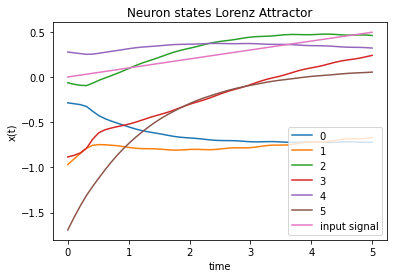

In [5]:
# drive system on lorenz attractor
parameters_training = (tau, leaking_matrix, internal_weights, input_weights, 0)
training_data_lorenz = odeint(leaky_esn_two_inputs, np.random.standard_normal(N), t, parameters_training)
plot_liquid_states(training_data_lorenz, title="Neuron states Lorenz Attractor")

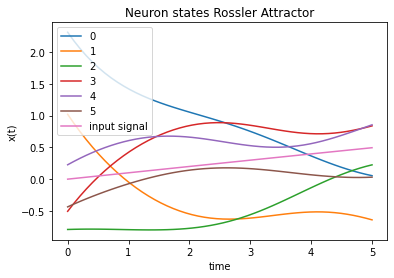

In [6]:
# drive system on rossler attractor
parameters_training = (tau, leaking_matrix, internal_weights, input_weights, 1)
training_data_rossler = odeint(leaky_esn_two_inputs, np.random.standard_normal(N), t, parameters_training)
plot_liquid_states(training_data_rossler, "Neuron states Rossler Attractor")

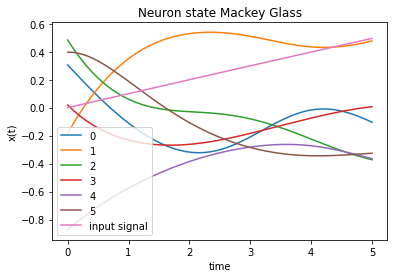

In [7]:
# drive system on Mackey-Glass attractor
parameters_training = (tau, leaking_matrix, internal_weights, input_weights, 2)
training_data_mg = odeint(leaky_esn_two_inputs, np.random.standard_normal(N), t, parameters_training)
plot_liquid_states(training_data_mg, title="Neuron state Mackey Glass")

In [ ]:
# print(training_data_lorenz.shape)
# print(training_data_rossler.shape)
# print(training_data_mg.shape)
# Compute and test readout weights
state_trajectories = [training_data_lorenz, training_data_rossler, training_data_mg]
input_matrices = [generate_pattern_matrix_from_dict(lorenz_input), generate_pattern_matrix_from_dict(rossler_input), generate_pattern_matrix_from_dict(mg_input)]
print(np.array(generate_pattern_matrix_from_dict(lorenz_input)).shape)
# print(len(generate_pattern_matrix_from_dict(lorenz_input)))

loading_weights = compute_loading_weights(state_trajectories)
readout_weights = compute_output_weights(state_trajectories, input_matrices)
conceptors = [compute_conceptor(x, 10000) for x in state_trajectories]

print(readout_weights.shape)

In [ ]:
control_errors = [[] for x in range(number_of_patterns)]
control_distance = [[] for x in range(number_of_patterns)]
retrieval_data = []
# Test training output weights
for i in range(number_of_patterns):
    parameters_training = (tau, leaking_matrix, internal_weights, input_weights, i, conceptors[i],control_errors, control_distance)
    test_data_attractor = odeint(leaky_esn_two_inputs_control, np.random.standard_normal(N), t, parameters_training)
    retrieval_data.append(test_data_attractor) 

In [ ]:
def get_input_for_plotting(i):
    if i == 0:
        return plot_input_data_attractors(lorenz_input, get_data=True)
    if i == 1:
        return plot_input_data_attractors(rossler_input, get_data=True)
    if i == 2:
        return plot_input_data_attractors(mg_input, get_data=True)


In [ ]:
# Compute loading weights
for idx, test_data_attractor in enumerate(retrieval_data):
    fix, axs = plt.subplots(2,2)
    x1, x2 = compute_output(test_data_attractor, output_weights, True)
    x1 = normalise_time_series(x1)
    x2 = normalise_time_series(x2)
   
    axs[0, 0].plot(x1, x2)
    axs[0, 0].set_title('Retrieval output')

    axs[0, 1].plot(control_distance[i])
    axs[0, 1].set_title("Control distance")

    axs[0,1].set_title("Training data")
    axs[1,1].set_title("control error per neuron")

    goal1, goal2 = get_input_for_plotting(idx)
    axs[1,0].plot(goal1, goal2)
    axs[1,0].set_title("goal output")
    # for j in range(5):
    #     idx = random.randint(0, N-1)
    #     print(idx)
    #     control_error = list(control_errors[j])[0]
    #     print(control_error)
    #     control_signal_neuron = control_error[:, idx] 
    #     axs[1,1].plot(control_signal_neuron)
    #     axs[1,0].plot(test_dakta_attractor[:, idx])
    plt.show()